<a href="https://colab.research.google.com/github/Galahexolion/Giliojo-mokymo-sistem-taikymai/blob/main/Lab9_AE/lab9_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- 1. KONFIGŪRACIJA ---

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

latent_dim = 2
input_shape = (28, 28, 1)
num_classes = 10

In [2]:
# --- 2. ENCODER ---
image_input = Input(shape=input_shape, name="image_input")
label_input = Input(shape=(num_classes,), name="label_input") # Pridedame labelį (Conditional VAE)

# Sujungiame vaizdą su etikete (kad galėtume prašyti "nupiešk penketą")
label_dense = layers.Dense(np.prod(input_shape), activation="relu")(label_input)
label_reshaped = layers.Reshape(input_shape)(label_dense)
enc_in = layers.Concatenate(axis=-1)([image_input, label_reshaped])

x = layers.Conv2D(32, 3, activation="relu", padding="same")(enc_in)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Reparameterization trick (Būtina VAE)
def sampling(args):
    z_m, z_lv = args
    eps = tf.random.normal(shape=tf.shape(z_m))
    return z_m + tf.exp(0.5 * z_lv) * eps

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
encoder = Model([image_input, label_input], [z_mean, z_log_var, z], name="encoder")

In [3]:
# --- 3. DECODER ---
z_in = Input(shape=(latent_dim,), name="z_in")
decoder_lbl = Input(shape=(num_classes,), name="decoder_label")
dec_concat = layers.Concatenate(axis=-1)([z_in, decoder_lbl])

x = layers.Dense(7 * 7 * 64, activation="relu")(dec_concat)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
decoded = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)

decoder = Model([z_in, decoder_lbl], decoded, name="decoder")

In [4]:
# --- 4. VAE MODELIS (Su Custom Loss) ---
class CVAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        # Išpakuojame duomenis (x, y)
        if isinstance(data, tuple): data = data[0]
        x, y_onehot = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([x, y_onehot])
            reconstruction = self.decoder([z, y_onehot])

            # Reconstruction Loss (MSE)
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(x - reconstruction), axis=(1, 2, 3))
            )
            # KL Divergence Loss (kad latentinė erdvė būtų tvarkinga)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

In [6]:
# --- 5. MOKYMAS ---
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=tf.keras.optimizers.Adam())

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Paruošimas
x_train = np.expand_dims(x_train.astype("float32") / 255.0, -1)
# Pakeičiame etiketes į One-Hot (būtina šiam VAE modeliui)
y_train_oh = to_categorical(y_train, num_classes)

print("Pradedamas VAE mokymas (gali užtrukti porą minučių)...")
# Mokome
cvae.fit([x_train, y_train_oh], epochs=10, batch_size=128, verbose=1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Pradedamas VAE mokymas (gali užtrukti porą minučių)...
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 191s 400ms/step - kl_loss: 0.6766 - loss: 67.3482 - recon_loss: 66.6716
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 186s 396ms/step - kl_loss: 1.1719 - loss: 39.2852 - recon_loss: 38.1133
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 397ms/step - kl_loss: 1.5836 - loss: 36.1503 - recon_loss: 34.5667
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 392ms/step - kl_loss: 1.8073 - loss: 34.5947 - recon_loss: 32.7874
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 389ms/step - kl_loss: 1.8483 - loss: 34.2930 - recon_loss: 32.4446
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 390ms/step - kl_loss: 1.8825 - loss: 34.0833 - recon_loss: 32.2007
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 184s 393ms/step - kl_loss: 2.0504 - loss: 33.7680 - recon_loss: 31.7176
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 183s 390ms/step - kl_loss: 3.1354 - loss: 31.2859 - recon_loss: 28.150


Generuojame naujus skaičius...


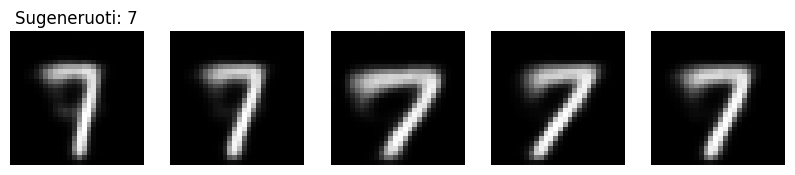

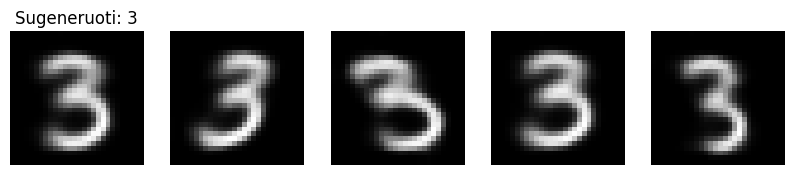

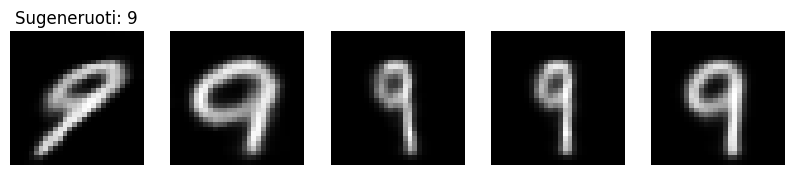

In [7]:
# --- 6. GENERAVIMAS ---
print("\nGeneruojame naujus skaičius...")

def generate_digit(digit_label, n=5):
    # Sukuriame norimą etiketę (pvz., visi 7)
    label_vec = to_categorical([digit_label]*n, num_classes)

    # Imame atsitiktinius taškus iš latentinės erdvės (normalusis skirstinys)
    z_sample = np.random.normal(size=(n, latent_dim))

    # Dekoduojame (generuojame vaizdą)
    generated_imgs = decoder.predict([z_sample, label_vec], verbose=0)

    # Atvaizduojame
    plt.figure(figsize=(n*2, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated_imgs[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0: ax.set_title(f"Sugeneruoti: {digit_label}")
    plt.show()

# Išbandykite generavimą!
generate_digit(7, n=5) # Sugeneruos 5 septynetus
generate_digit(3, n=5) # Sugeneruos 5 trejetus
generate_digit(9, n=5) # Sugeneruos 5 devynetus